---
# <center> Master M2 MVA - Computational Statistics
    
# <center>  TP 3: Hasting-Metropolis (and Gibbs) samplers
    
<center> Basile Terver
<center> terverbasile@gmail.com
    
    
--- 

In [1]:
import sys
print(sys.path)

import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.stats import invwishart
from numba import jit
from tqdm import tqdm
from IPython import get_ipython

['/mnt/c/Users/terve/Documents/Info/Computational statistics/TPs/TP3', '/home/terverbaunix/miniconda3/envs/Compstats/lib/python311.zip', '/home/terverbaunix/miniconda3/envs/Compstats/lib/python3.11', '/home/terverbaunix/miniconda3/envs/Compstats/lib/python3.11/lib-dynload', '', '/home/terverbaunix/miniconda3/envs/Compstats/lib/python3.11/site-packages']


## 1.A – A population model for longitudinal data

### Question 2

In [2]:
# Fix values of the parameters given in Question 2 of the Handout
N = 100
ki = 20

p0 = 1

sigma_t0 = 0.1
sigma_v0 = 0.1

s_t0 = 0.1
s_v0 = 0.1

t0barbar = 1
v0barbar = 1

m = 8
m_xi = m
m_tau = m

v = 1.9
v_xi = v
v_tau = v

In [3]:
#Sample the 5 parameters of the model from the values given above
t0bar = np.random.normal(t0barbar, s_t0)
v0bar = np.random.normal(v0barbar, s_v0)
sigma2_xi = invwishart.rvs(m_xi,v_xi)
sigma2_tau = invwishart.rvs(m_tau,v_tau)
sigma2 = invwishart.rvs(m,v)

#Sample global latent variables from the model's parameters (p0 is fixed)
t0 = np.random.normal(t0bar, s_t0)
v0 = np.random.normal(v0bar, s_v0)

#Sample individual latent variables from the model's parameters
xi = np.random.normal(0,np.sqrt(sigma2_xi),N)
alpha = np.exp(xi)
tau = np.random.normal(0,np.sqrt(sigma2_tau),N)

In [4]:
#Define average progression
@jit(nopython=True)
def d(p0, t0, v0,t):
    return v0*(t - t0)+p0

In [5]:
#Generate the yij's from the latent variables and model's parameters
@jit(nopython=True)
def synthetic_data(p0=p0,t0=t0, v0=v0,alpha=alpha, tau=tau, sigma2=sigma2, ki=ki):
    N = len(alpha)
    res = np.zeros((N,ki))
    for j in range(ki):
        res[:,j] = d(p0,t0,v0,alpha * (j-t0-tau) + t0)
        
    eps = np.random.normal(0,np.sqrt(sigma2),(N,ki))
    res+= eps
    return res,t0,v0,np.log(alpha),tau

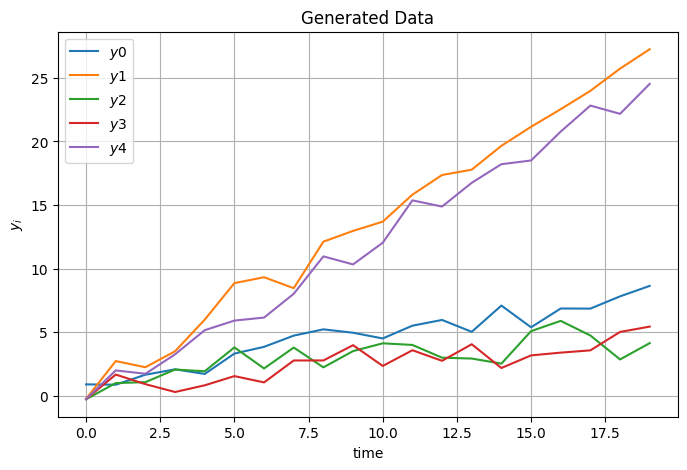

In [6]:
#Generate data using above function
Y,true_t0,true_v0,true_xi,true_tau=synthetic_data()

#Plot the individual trajectories
plt.figure(figsize=(8,5))
for i in range(5):
    plt.plot(np.arange(ki), Y[i,:] , label = '$y$'+str(i))

plt.title('Generated Data')
plt.xlabel("time")
plt.ylabel("$y_{i}$")
plt.legend()
plt.grid(True)
plt.show()

## 1.B – HM-SAEM – Hasting-Metropolis sample

### Question 3

We have 
$$\log p(z|y,\theta)=\log p(y|z,\theta)+\log p(z|\theta)+C'',
$$ with $C''$ independent of $z$.
Therefore we have 
$$\begin{aligned}
\log p(z|y,\theta)=-\frac{1}{2\sigma^2}\sum_{i=1}^N\sum_{j=1}^{k_i}(y_{ij}-d_i(t_{ij}))^2 - \sum_{i=1}^N[\xi_i+\frac{\xi_i^2}{2\sigma_{\xi}^2}] \\
-\frac{1}{2\sigma_{\tau}^2}\sum_{i=1}^N\tau_i^2
- \frac{(t_0-\bar{\bar{t_0}})^2}{2\sigma_{t_0}^2}
- \frac{(v_0-\bar{v_0})^2}{2\sigma_{v_0}^2},
\end{aligned}
$$
up to a constant independent of $z$.

In [7]:
true_z = np.zeros(2*N+2)
true_z[0] = true_t0
true_z[1] = true_v0
true_z[2:N+2] = true_xi.reshape((N,))
true_z[N+2:] = true_tau.reshape((N,))

In [8]:
#To gain a lot of time in SAEM
@jit(nopython=True)
def y_gap(Y, t0, v0, xi, tau, p0 = p0):
    res = np.zeros((Y.shape[0],ki))
    for t in range(ki):
        res[:, t] = Y[:, t] - (p0 + (v0*np.exp(xi)*(t-t0-tau)).reshape((Y.shape[0],)))
    return res

In [9]:
# Formula for the log posterior likelihood up to a constant independent of z
@jit(nopython=True)
def log_posterior(Y, z, p0, t0, t0bar, v0bar, sigma_t0,sigma2, sigma_v0, sigma2_xi_proposal, sigma2_tau_proposal):
    
    t0, v0 = z[0:2]
    xi = z[2:N+2].reshape(-1, 1)  # (N, 1)
    tau = z[N+2:].reshape(-1, 1)  # (N, 1)
    
    ygap = y_gap(Y, t0, v0, xi, tau,p0)

    dz = np.sum(np.square(ygap))/2*sigma2
    
    pz = (  np.sum(xi + xi ** 2) / (2 * sigma2_xi_proposal)
            + np.sum(tau ** 2) / (2 * sigma2_tau_proposal)
            + (t0 - t0bar) ** 2 / (2 * sigma_t0**2)
            + (v0 - v0bar) ** 2 / (2 * sigma_v0**2))
    
    return -dz- pz


In [10]:

def SRWHM(Y, z_init, t0bar, v0bar, sigma2_xi, sigma2_tau, sigma2, sigma2_prop, maxIter = 10000):

    count = 0
    z_current = z_init
    
    for k in range(maxIter):
        # Sample the proposal zstar
        zstar = np.random.randn(z_current.shape[0])*np.sqrt(sigma2_prop) + z_current

        #Acceptance probability
        log_pi_zstar = log_posterior(Y, zstar,p0,t0 ,t0bar, v0bar,sigma_t0,sigma2,sigma_v0, sigma2_xi, sigma2_tau)
        log_pi_zk =  log_posterior(Y, z_current,p0,t0 ,t0bar, v0bar,sigma_t0,sigma2,sigma_v0, sigma2_xi, sigma2_tau)
        log_ratio = log_pi_zstar - log_pi_zk

        acceptance_ratio = min(1, np.exp(min(0, log_ratio)))
        
        # Acceptance-rejection
        u = np.random.rand()
        if u < acceptance_ratio:
            z_current = zstar
            count += 1
    
    return z_current, count/maxIter

In [11]:
z_init = true_z + np.random.randn(true_z.shape[0])*0.05

z_pred, acceptance_rate = SRWHM(Y, z_init, t0bar, v0bar, sigma2_xi, sigma2_tau, sigma2, 5*1e-5, maxIter = 100)

In [12]:
print("Acceptance Rate: ", acceptance_rate)
print("True t0: ", true_t0)
print("True v0: ", true_v0)

print("Predicted t0: ", z_pred[0])
print("Predicted v0: ", z_pred[1])

Acceptance Rate:  0.17
True t0:  1.0931584252737825
True v0:  0.9705863481775562
Predicted t0:  1.1116726933151635
Predicted v0:  0.9719451502970029


## Question 4: HM-SAEM

In [13]:
# True model parameters theta from which we generated the data
true_t0bar = t0bar
true_v0bar=v0bar 
true_sigma2_xi=sigma2_xi
true_sigma2_tau=sigma2_tau
true_sigma2=sigma2

We don't follow the same indexing of the components of S as in the answer to the theoretical question for readability

In [14]:

def MCMC_SAEM(Y, t0bar_init, v0bar_init, sigma2_xi_init, sigma2_tau_init, sigma2_init, sigma2_prop = 3*1e-6,\
               burn_in = 50, alpha = 0.8, maxIter = 1000):
    # Initialize parameters
    t0bar = t0bar_init
    v0bar = v0bar_init
    sigma2_xi = sigma2_xi_init
    sigma2_tau = sigma2_tau_init
    sigma2 = sigma2_init

    # Lists to store parameter estimates at each iteration
    all_t0bar = [t0bar_init]
    all_v0bar = [v0bar_init]
    all_sigma2_xi = [sigma2_xi_init]
    all_sigma2_tau = [sigma2_tau_init]
    all_sigma2 = [sigma2_init]

    # Initialize sufficient statistics
    z_init = true_z
    S = np.zeros((5,1))
    t0_init = z_init[0]
    v0_init = z_init[1]
    xi_init = z_init[2:N+2]
    tau_init = z_init[N+2:]

    y_gaps_init = y_gap(Y, t0_init, v0_init, xi_init, tau_init)
    
    S[0] = t0_init
    S[1] = v0_init
    S[2] = np.sum(np.square(xi_init))
    S[3] = np.sum(np.square(tau_init))
    S[4] = np.sum(np.square(y_gaps_init))
    
    z = z_init
    
    #Step sizes
    epsilons = np.ones(maxIter)
    epsilons[burn_in+1:] = np.array([(i - burn_in)**(- alpha) for i in range(burn_in+1, maxIter)])
    avg_acceptation_rate = 0

    for l in range(maxIter):
        # E step: Simulation from the log
        z, acceptation_rate = SRWHM(Y, z, t0bar, v0bar, sigma2_xi, sigma2_tau, sigma2, sigma2_prop, maxIter = 100)
        avg_acceptation_rate += acceptation_rate 

        # Compute z^(k+1)
        t0 = z[0]
        v0 = z[1]
        xi = z[2:N+2]
        tau = z[N+2:]

        y_gaps = y_gap(Y, t0, v0, xi, tau)

        #Stochastic approximation step
        #Compute S^(k+1)
        S[0] += epsilons[l] * (t0- S[0]) 
        S[1] += epsilons[l] * (v0- S[1])
        S[2] += epsilons[l] * (np.sum(np.square(xi))- S[2])
        S[3] += epsilons[l] * (np.sum(np.square(tau))- S[3])
        S[4] += epsilons[l] * (np.sum(np.square(y_gaps))- S[4])

        # M step using the explicit formulas derived by hand
        t0bar = ((s_t0**2) *S[0] + (sigma_t0**2) * t0barbar) / (s_t0**2 + sigma_t0**2)
        v0bar = ((s_v0**2) *S[1] + (sigma_v0**2) * v0barbar) / (s_v0**2 + sigma_v0**2)
        sigma2_xi = (v_xi**2 + S[2]) / (m_xi + N + 2)
        sigma2_tau = (v_tau**2 + S[3]) / (m_tau + N + 2)
        sigma2 = (v**2 + S[4]) / (m + N*ki + 2)

        
        all_t0bar.append(float(t0bar))
        all_v0bar.append(float(v0bar))
        all_sigma2_xi.append(float(sigma2_xi))
        all_sigma2_tau.append(float(sigma2_tau))
        all_sigma2.append(float(sigma2))

    avg_acceptation_rate = round(avg_acceptation_rate / maxIter, 2)
    print("Average acceptance rate in the HM runs : ", avg_acceptation_rate)
    return t0bar, v0bar, sigma2_xi, sigma2_tau, sigma2, all_t0bar, all_v0bar, all_sigma2_xi, all_sigma2_tau, all_sigma2


In [15]:
t0bar_init = 0.5
v0bar_init = 0.5
sigma2_xi_init = 0.1
sigma2_tau_init = 0.1
sigma2_init = 0.1

t0bar, v0bar, sigma2_xi, sigma2_tau, sigma2, all_t0bar, all_v0bar, all_sigma2_xi, all_sigma2_tau, all_sigma2 = MCMC_SAEM(Y,\
                                                         t0bar_init, v0bar_init, sigma2_xi_init, sigma2_tau_init, sigma2_init)

print("True t0bar : ", true_t0bar)
print("True v0bar : ", true_v0bar)
print("True sigma2_xi : ", true_sigma2_xi)
print("True sigma2_tau : ", true_sigma2_tau)
print("True sigma2 : ", true_sigma2)

print("Estimated t0bar : ", t0bar)
print("Estimated v0bar : ", v0bar)
print("Estimated sigma2_xi : ", sigma2_xi)
print("Estimated sigma2_tau : ", sigma2_tau)
print("Estimated sigma2 : ", sigma2)

/tmp/ipykernel_190492/4294549844.py:69: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_t0bar.append(float(t0bar))
/tmp/ipykernel_190492/4294549844.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_v0bar.append(float(v0bar))
/tmp/ipykernel_190492/4294549844.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  all_sigma2_xi.append(float(sigma2_xi))
/tmp/ipykernel_190492/4294549844.py:72: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar i

Average acceptance rate in the HM runs :  0.44
True t0bar :  0.8935585749092279
True v0bar :  0.9335970649958034
True sigma2_xi :  0.6400125819838216
True sigma2_tau :  0.4000091155523408
True sigma2 :  0.6000127321162659
Estimated t0bar :  [1.03526266]
Estimated v0bar :  [1.00813201]
Estimated sigma2_xi :  [0.81646736]
Estimated sigma2_tau :  [0.35663833]
Estimated sigma2 :  [0.66871094]


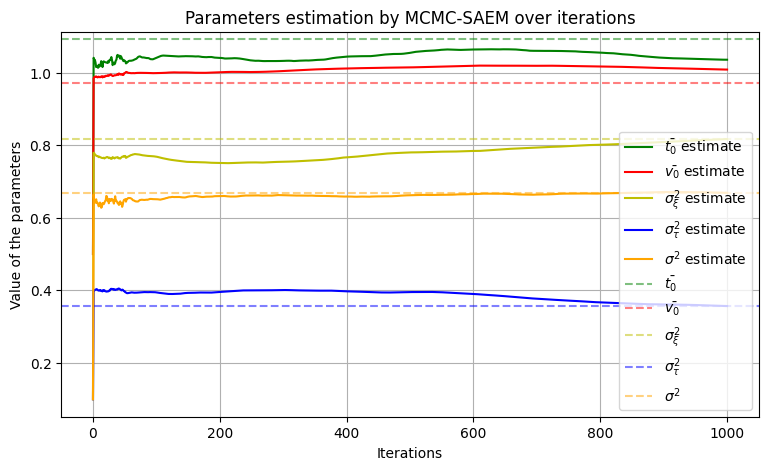

In [16]:
plt.figure(figsize=(9, 5))
plt.plot(all_t0bar, label=r"$\bar{t_0}$ estimate", c="g")
plt.plot(all_v0bar, label=r"$\bar{v_0}$ estimate", c="r")
plt.plot(all_sigma2_xi, label=r"$\sigma^2_{\xi}$ estimate", c="y")
plt.plot(all_sigma2_tau, label=r"$\sigma^2_{\tau}$ estimate", c="b")
plt.plot(all_sigma2, label=r"$\sigma^2$ estimate", c="orange")
#plot true value with same color
plt.axhline(t0, label=r"$\bar{t_0}$", c="g", ls="--", alpha=0.5)
plt.axhline(v0, label=r"$\bar{v_0}$", c="r", ls="--", alpha=0.5)
plt.axhline(sigma2_xi, label=r"$\sigma^2_{\xi}$", c="y", ls="--", alpha=0.5)
plt.axhline(sigma2_tau, label=r"$\sigma^2_{\tau}$", c="b", ls="--", alpha=0.5)
plt.axhline(sigma2, label=r"$\sigma^2$", c="orange", ls="--", alpha=0.5)
plt.legend()
plt.title("Parameters estimation by MCMC-SAEM over iterations")
plt.xlabel("Iterations")
plt.ylabel("Value of the parameters")
plt.grid(True)

The convergence is very satisfying. There just seems to sometimes be a problem with the estimation of $\bar{v_0}$.

## 1.C – HMwG-SAEM – Hasting-Metropolis within Gibbs sampler

### Questions 5 to 7

As explained in the scanned answers, we have 
$$\begin{aligned}
\log p(z_i|z_{pop}y,\theta)=-\frac{1}{2\sigma^2}\sum_{j=1}^{k_i}(y_{ij}-d_i(t_{ij}))^2 -[\xi_i+\frac{\xi_i^2}{2\sigma_{\xi}^2}] 
-\frac{1}{2\sigma_{\tau}^2}\tau_i^2,
\end{aligned}
$$
up to a constant independent of $z_i$, for all $i\in\{1,\dots,N\}$.

In [17]:
#@jit(nopython=True)
def log_posterior_zi(idx,Y, z, sigma2,sigma2_xi, sigma2_tau):
    t0 = z[0]
    v0 = z[1]
    xi = z[2:N+2].reshape((N,))
    xi=xi[idx]
    tau = z[N+2:].reshape((N,))
    tau=tau[idx]

    #y_gaps = y_gap(Y, t0, v0, xi, tau)
    #y_gaps=y_gaps[idx]
    y_gaps = np.zeros((ki,))
    for t in range(ki):
        y_gaps[t] = Y[idx, t] - (p0 + (v0*np.exp(xi)*(t-t0-tau)))
    
    res = np.sum(np.square(y_gaps)) / (2*sigma2)
    res += xi
    res += np.square(np.exp(xi)) / (2*sigma2_xi)
    res += np.square(tau) / (2*sigma2_tau)
    return -res

As explained in the scanned answers, we have 
$$\begin{aligned}
\log p(z_{pop}|\{z_i\}_i,y,\theta)=-\frac{1}{2\sigma^2}\sum_{j=1}^{k_i}(y_{ij}-d_i(t_{ij}))^2 - \frac{t_0^2}{2\sigma_{t_0}^2} +\frac{t_0\bar{t_0}}{\sigma_{t_0}^2} \\
 - \frac{v_0^2}{2\sigma_{v_0}^2} +\frac{v_0\bar{t_0}}{\sigma_{v_0}^2},
\end{aligned}
$$
up to a constant independent of $z_{pop}$.

In [18]:
#@jit(nopython=True)
def log_posterior_zpop(Y, z,t0bar, v0bar, sigma2):
    t0 = z[0]
    v0 = z[1]
    xi = z[2:N+2].reshape((N,))
    tau = z[N+2:].reshape((N,))

    y_gaps = y_gap(Y, t0, v0, xi, tau)
    
    res = -np.sum(np.square(y_gaps)) / (2*sigma2)
    res -= np.square(t0) / (2*sigma_t0**2)
    res += t0*t0bar / (sigma_t0**2)
    res -= np.square(v0) / (2*sigma_v0**2)
    res += v0*v0bar / (sigma_v0**2)
    return res

In [19]:

def SRWHMwG_zi(idx,Y, z_init, sigma2_xi, sigma2_tau, sigma2, sigma2_prop=0.1, maxIter = 10000):

    z_current = z_init
    z_idx_current = [z_init[idx + 2], z_init[N+2+idx]] 

    count = 0

    for k in range(maxIter):
        # Sample the proposal zstar
        zstar_idx = np.random.randn(2)*np.sqrt(sigma2_prop) + z_idx_current
        
        zstar = z_current.copy()
        zstar[idx+2] = zstar_idx[0]
        zstar[N+2+idx] = zstar_idx[1]

        #Acceptance probability
        log_pi_zstar = log_posterior_zi(idx,Y, zstar,sigma2, sigma2_xi, sigma2_tau)
        log_pi_zk =  log_posterior_zi(idx,Y, z_current,sigma2, sigma2_xi, sigma2_tau)
        log_ratio = log_pi_zstar - log_pi_zk

        acceptance_ratio = min(1, np.exp(min(0, log_ratio)))
        
        # Acceptance-rejection
        u = np.random.rand()
        if u < acceptance_ratio:
            z_current = zstar
            count += 1
            z_idx_current=zstar_idx
    
    return z_current, count/maxIter

In [20]:
def SRWHMwG_zpop(Y, z_init,t0bar, v0bar, sigma2, sigma2_prop=0.1, maxIter = 10000):
    
    z_current = z_init
    zpop_current = z_init[0:2]

    count = 0

    for k in range(maxIter):
        # Sample the proposal zstar
        zstar_pop = np.random.randn(zpop_current.shape[0])*np.sqrt(sigma2_prop) + zpop_current
        
        zstar = z_current.copy()
        zstar[0:2]=zstar_pop

        #Acceptance probability
        log_pi_zstar = log_posterior_zpop(Y, zstar,sigma2, sigma2_xi, sigma2_tau)
        log_pi_zk =  log_posterior_zpop(Y, z_current,sigma2, sigma2_xi, sigma2_tau)
        log_ratio = log_pi_zstar - log_pi_zk

        acceptance_ratio = min(1, np.exp(min(0, log_ratio)))
        
        # Acceptance-rejection
        u = np.random.rand()
        if u < acceptance_ratio:
            z_current = zstar
            count += 1
            zpop_current = zstar_pop
    
    return z_current, count/maxIter

In [21]:
z_init = np.zeros(2*N+2)+0.1

idx = np.random.randint(0, N)
print("Test SRWHMwG for zi with i = ", idx)

z_estimate, acceptance_rate = SRWHMwG_zi(idx, Y, z_init, sigma2_xi, sigma2_tau, sigma2)

print("True xi_",idx," : ", true_xi[idx])
print("True tau_",idx," : ", true_tau[idx])

print("Estimated xi_",idx," : ", z_estimate[idx+2])
print("Estimated tau_",idx," : ", z_estimate[idx+2+N])

Test SRWHMwG for zi with i =  46


True xi_ 46  :  -0.06743611431326926
True tau_ 46  :  0.09533090964834925
Estimated xi_ 46  :  2.1925217400076473
Estimated tau_ 46  :  1.1221891235655475


I stop at this point as I do not have enough time to debug my SRWHMwG_zi function.

## Exercise 2

The first distribution we sample from is the exponential distribution, from which we can sample using the inverse transformation method.

The second one is the Gaussian distribution. 

In [22]:
def Multiplicative_HM(x0,N,pi):
    chain = [x0]
    X = x0
    
    for i in range(N):
        eps = np.random.uniform(-1,1)
        B = np.random.binomial(1, 0.5)
        proposal = eps*X*B + X/eps*np.abs(1-B) 
        
        u = np.random.random() 
        alpha = min (1,(pi(proposal)*np.abs(proposal))/(pi(X)*np.abs(X)))
        
        if u < alpha :
            chain.append(proposal)
            X = proposal 
        
    return chain

In [23]:
# First distribution: Exp(2)
inv_lam= 0.5
expon = scipy.stats.expon(scale=inv_lam)

# Second distribution: N(0, 9).
m=0
sigma=3
gaussian = scipy.stats.norm(loc=m, scale=sigma)

In [24]:
# Set hyperparameters
N = 10000
x0=1

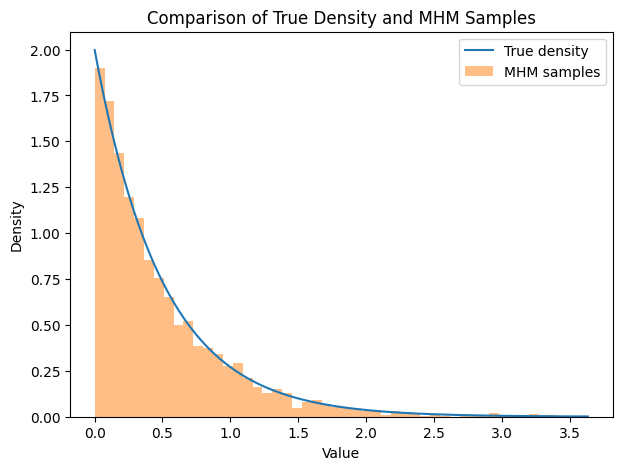

In [25]:
chain_expon = Multiplicative_HM(x0=x0, N=N,pi=expon.pdf)

# True density
x = np.linspace(min(chain_expon),max(chain_expon),1000)
exp = expon.pdf(x)

plt.figure(figsize=(7,5))
plt.plot(x , exp  , label = 'True density')
plt.hist(chain_expon , bins = 50 , density = True , alpha=0.5 , label = 'MHM samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Comparison of True Density and MHM Samples')
plt.legend()
plt.show()

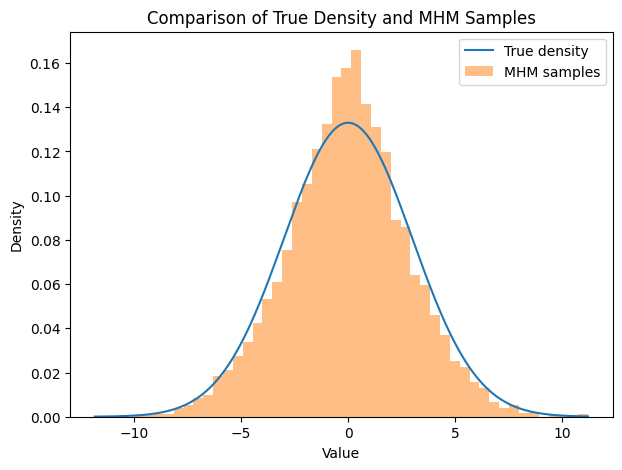

In [26]:
chain_gauss = Multiplicative_HM(x0=x0, N=N,pi=gaussian.pdf)

# True density
x = np.linspace(min(chain_gauss),max(chain_gauss),1000)
gauss = gaussian.pdf(x)

plt.figure(figsize=(7,5))
plt.plot(x , gauss  , label = 'True density')
plt.hist(chain_gauss , bins = 50 , density = True , alpha=0.5 , label = 'MHM samples')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Comparison of True Density and MHM Samples')
plt.legend()
plt.show()